# ASL Fingerspelling Recognizer and Predictor
### Imports

In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import tensorflow as tf
import json
import mediapipe
import matplotlib
import matplotlib.pyplot as plt
import random

from skimage.transform import resize
from mediapipe.framework.formats import landmark_pb2
from tensorflow import keras
from tensorflow.keras import layers

%load_ext autoreload
%autoreload 2

In [3]:
ds_path = os.environ.get('SIS_DATASET_INPUT_PATH')
ds_out_path = os.environ.get('SIS_DATASET_PREPROC_PATH')
dsdf = pd.read_csv(os.path.join(ds_path, 'train.csv')) # Modify path to match kaggle dataset path
print("Dataset Shape: {}".format(dsdf.shape))

dsdf.head()


Dataset Shape: (67208, 5)


,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


## Process Dataset from Parquets to TFRecord

In [4]:
# This is taken from the Google example notebook for processing data
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
POSE = LPOSE + RPOSE

X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]

FEATURE_COLUMNS = X + Y + Z

X_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "x_" in col]
Y_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "y_" in col]
Z_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "z_" in col]

RHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col[-2:]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col[-2:]) in LPOSE]

In [5]:
from tqdm.notebook import tqdm

tfrec_path = os.path.join(ds_out_path, 'tfrecords')

# Set length of frames to 128
FRAME_LEN = 128

# Create directory to store the new data
if not os.path.isdir("preprocessed"):
    os.mkdir("preprocessed")
else:
    shutil.rmtree("preprocessed")
    os.mkdir("preprocessed")

# Loop through each file_id
for file_id in tqdm(dsdf.file_id.unique()):
    # Parquet file name
    
    # pq_file = f"/kaggle/input/asl-fingerspelling/train_landmarks/{file_id}.parquet"
    pq_file = os.path.join(ds_path, 'train_landmarks', f'{file_id}.parquet')

    # Filter train.csv and fetch entries only for the relevant file_id
    file_df = dsdf.loc[dsdf["file_id"] == file_id]
    # Fetch the parquet file
    parquet_df = pq.read_table(pq_file,
                              columns=['sequence_id'] + FEATURE_COLUMNS).to_pandas()
    # File name for the updated data
    tf_file = os.path.join(tfrec_path, f"{file_id}.tfrecord")
    parquet_numpy = parquet_df.to_numpy()
    # Initialize the pointer to write the output of 
    # each `for loop` below as a sequence into the file.
    with tf.io.TFRecordWriter(tf_file) as file_writer:
        # Loop through each sequence in file.
        for seq_id, phrase in zip(file_df.sequence_id, file_df.phrase):
            # Fetch sequence data
            frames = parquet_numpy[parquet_df.index == seq_id]
            
            # Calculate the number of NaN values in each hand landmark
            r_nonan = np.sum(np.sum(np.isnan(frames[:, RHAND_IDX]), axis = 1) == 0)
            l_nonan = np.sum(np.sum(np.isnan(frames[:, LHAND_IDX]), axis = 1) == 0)
            no_nan = max(r_nonan, l_nonan)
            
            if 2*len(phrase)<no_nan:
                features = {FEATURE_COLUMNS[i]: tf.train.Feature(
                    float_list=tf.train.FloatList(value=frames[:, i])) for i in range(len(FEATURE_COLUMNS))}
                features["phrase"] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(phrase, 'utf-8')]))
                record_bytes = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString()
                file_writer.write(record_bytes)

  0%|          | 0/68 [00:00<?, ?it/s]

In [6]:
tf_records = dsdf.file_id.map(lambda x: os.path.join(tfrec_path, f'{x}.tfrecord')).unique()
print(f"List of {len(tf_records)} TFRecord files.")

print(FEATURE_COLUMNS)

List of 68 TFRecord files.
['x_right_hand_0', 'x_right_hand_1', 'x_right_hand_2', 'x_right_hand_3', 'x_right_hand_4', 'x_right_hand_5', 'x_right_hand_6', 'x_right_hand_7', 'x_right_hand_8', 'x_right_hand_9', 'x_right_hand_10', 'x_right_hand_11', 'x_right_hand_12', 'x_right_hand_13', 'x_right_hand_14', 'x_right_hand_15', 'x_right_hand_16', 'x_right_hand_17', 'x_right_hand_18', 'x_right_hand_19', 'x_right_hand_20', 'x_left_hand_0', 'x_left_hand_1', 'x_left_hand_2', 'x_left_hand_3', 'x_left_hand_4', 'x_left_hand_5', 'x_left_hand_6', 'x_left_hand_7', 'x_left_hand_8', 'x_left_hand_9', 'x_left_hand_10', 'x_left_hand_11', 'x_left_hand_12', 'x_left_hand_13', 'x_left_hand_14', 'x_left_hand_15', 'x_left_hand_16', 'x_left_hand_17', 'x_left_hand_18', 'x_left_hand_19', 'x_left_hand_20', 'x_pose_13', 'x_pose_15', 'x_pose_17', 'x_pose_19', 'x_pose_21', 'x_pose_14', 'x_pose_16', 'x_pose_18', 'x_pose_20', 'x_pose_22', 'y_right_hand_0', 'y_right_hand_1', 'y_right_hand_2', 'y_right_hand_3', 'y_right_hand

In [7]:
with open (os.path.join(ds_path, 'character_to_prediction_index.json'), "r") as f:
    char_to_num = json.load(f)

# Token definitions
pad_token = 'P'
start_token = '<'
end_token = '>'
pad_token_index = 59
start_token_index = 60
end_token_index = 61

char_to_num[pad_token] = pad_token_index
char_to_num[start_token] = start_token_index
char_to_num[end_token] = end_token_index
num_to_char = {j:i for i,j in char_to_num.items()}

In [8]:
# This was taken from: https://www.kaggle.com/code/irohith/aslfr-transformer/notebook

# Function to resize and add padding.
def resize_pad(x):
    if tf.shape(x)[0] < FRAME_LEN:
        x = tf.pad(x, ([[0, FRAME_LEN-tf.shape(x)[0]], [0, 0], [0, 0]]))
    else:
        x = tf.image.resize(x, (FRAME_LEN, tf.shape(x)[1]))
    return x

# Detect the dominant hand from the number of NaN values.
# Dominant hand will have less NaN values since it is in frame moving.
def pre_process(x):
    rhand = tf.gather(x, RHAND_IDX, axis=1)
    lhand = tf.gather(x, LHAND_IDX, axis=1)
    rpose = tf.gather(x, RPOSE_IDX, axis=1)
    lpose = tf.gather(x, LPOSE_IDX, axis=1)
    
    rnan_idx = tf.reduce_any(tf.math.is_nan(rhand), axis=1)
    lnan_idx = tf.reduce_any(tf.math.is_nan(lhand), axis=1)
    
    rnans = tf.math.count_nonzero(rnan_idx)
    lnans = tf.math.count_nonzero(lnan_idx)
    
    # For dominant hand
    if rnans > lnans:
        hand = lhand
        pose = lpose
        
        hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
        hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
        hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
        hand = tf.concat([1-hand_x, hand_y, hand_z], axis=1)
        
        pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
        pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
        pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
        pose = tf.concat([1-pose_x, pose_y, pose_z], axis=1)
    else:
        hand = rhand
        pose = rpose
    
    hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
    hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
    hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
    hand = tf.concat([hand_x[..., tf.newaxis], hand_y[..., tf.newaxis], hand_z[..., tf.newaxis]], axis=-1)
    
    mean = tf.math.reduce_mean(hand, axis=1)[:, tf.newaxis, :]
    std = tf.math.reduce_std(hand, axis=1)[:, tf.newaxis, :]
    hand = (hand - mean) / std

    pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
    pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
    pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
    pose = tf.concat([pose_x[..., tf.newaxis], pose_y[..., tf.newaxis], pose_z[..., tf.newaxis]], axis=-1)
    
    x = tf.concat([hand, pose], axis=1)
    x = resize_pad(x)
    
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
    x = tf.reshape(x, (FRAME_LEN, len(LHAND_IDX) + len(LPOSE_IDX)))
    return x

In [9]:
def decode_func(record_bytes):
    schema = {col: tf.io.VarLenFeature(dtype=tf.float32) for col in FEATURE_COLUMNS}
    schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)
    features = tf.io.parse_single_example(record_bytes, schema)
    phrase = features["phrase"]
    landmarks = ([tf.sparse.to_dense(features[COL]) for COL in FEATURE_COLUMNS])
    landmarks = tf.transpose(landmarks)
    
    return landmarks, phrase

table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(list(char_to_num.keys())),
        values=tf.constant(list(char_to_num.values())),
    ),
    default_value=tf.constant(-1),
    name="class_weight"
)

def convert_func(landmarks, phrase):
    phrase = start_token + phrase + end_token # Set up phrase
    phrase = tf.strings.bytes_split(phrase)
    phrase = table.lookup(phrase)

    phrase = tf.pad(phrase, paddings=[[0, 64 - tf.shape(phrase)[0]]], mode='CONSTANT', constant_values=pad_token_index)
    return pre_process(landmarks), phrase

## Split and Train model

In [10]:
# Train and Split
batch_size = 128
train_len = int(0.8 * len(tf_records))
train_ds = tf.data.TFRecordDataset(tf_records[:train_len]).map(decode_func).map(convert_func).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()

valid_ds = tf.data.TFRecordDataset(tf_records[train_len:]).map(decode_func).map(convert_func).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()

In [12]:
from layers.transformer import Transformer

batch = next(iter(valid_ds))

idx_to_char = list(char_to_num.keys())

model = Transformer(
    hid = 200,
    heads = 4,
    numFeedForward=400,
    source_maxlen = FRAME_LEN,
    target_maxlen = 64,
    num_enc_layers=2,
    num_dec_layers=1,
    num_class=62,
)

loss_fun = tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1)

optmizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optmizer, loss=loss_fun)

history = model.fit(train_ds, validation_data=valid_ds, epochs=13) # TODO add prediction display

2023-10-03 09:38:37.660737: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 1/13
316/316 [==============================] - 451s 1s/step - loss: 0.9656 - edit_dist: inf - val_loss: 0.8808 - val_edit_dist: 0.9697
Epoch 2/13
316/316 [==============================] - 193s 610ms/step - loss: 0.8477 - edit_dist: 0.9597 - val_loss: 0.8330 - val_edit_dist: 0.9414
Epoch 3/13
316/316 [==============================] - 176s 556ms/step - loss: 0.8083 - edit_dist: 0.9374 - val_loss: 0.7969 - val_edit_dist: 0.9290
Epoch 4/13
316/316 [==============================] - 173s 548ms/step - loss: 0.7716 - edit_dist: 0.9229 - val_loss: 0.7650 - val_edit_dist: 0.9190
Epoch 5/13
316/316 [==============================] - 170s 537ms/step - loss: 0.7421 - edit_dist: 0.9116 - val_loss: 0.7428 - val_edit_dist: 0.9102
Epoch 6/13
316/316 [==============================] - 166s 525ms/step - loss: 0.7187 - edit_dist: 0.9030 - val_loss: 0.7254 - val_edit_dist: 0.9031
Epoch 7/13
316/316 [==============================] - 166s 526ms/step - loss: 0.6984 - edit_dist: 0.8958 - val_loss: 0

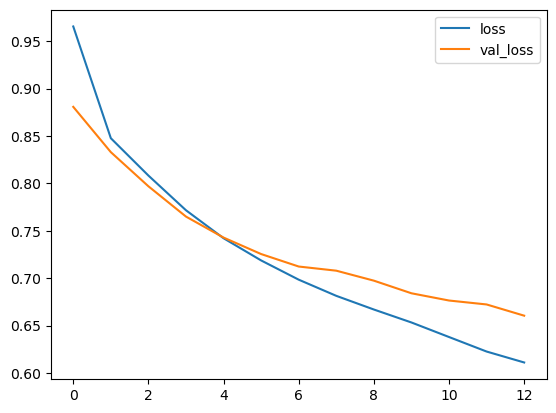

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])

# TF Lite Model Export

In [26]:
from converters.tf_lite_model import TFLiteModel

tf_model_obj = TFLiteModel(model, preprocess_fn=pre_process)
model.save_weights("/Volumes/Public/Datasets/asl_model_weights.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model_obj)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
# converter.experimental_new_convereter = True
lite_model = converter.convert()
with open("/Volumes/Public/Datasets/asl_model.tflife", 'wb') as f:
    f.write(lite_model)

infargs = {"selected_columns" : FEATURE_COLUMNS}
with open("/Volumes/Public/Datasets/asl_model.json", 'w') as json_f:
    json.dump(infargs, json_f)

TypeError: TFLiteModel.__init__() got an unexpected keyword argument 'preprocess_fn'